This Project will target Noise Complaints within the last 30 days
This Project will target the following:
1. It will pull up to 1000 noise complaint service requests from NYC's open data API
2. It will demonstrate a visualization of the data
3. It will include structured documentation to explain the process

In [1]:
import requests
import pandas as pd
from datetime import datetime, timedelta

def noise_complaints(days_back: int = 30,
                     limit: int = 1000,
                     api_token: str = None) -> pd.DataFrame:

    #Calculates and sets a stop date by using our parameter in our function which is 30 days. 
    #Essential for pulling the data from last 30 days
    stop_date = datetime.now() - timedelta(days = days_back)
    stop_date_iso = stop_date.isoformat()

    url = "https://data.cityofnewyork.us/resource/erm2-nwe9.json"

    #Set up our query and its parameters, for what we want to pull from the API we're using. 
    params = {
        "$select": "complaint_type,borough,created_date,descriptor",
        "$where": (
            f"created_date >= '{stop_date_iso}' "
            "AND complaint_type LIKE 'Noise%'"
        ),
        "$order": "created_date DESC",
        "$limit": limit #passes parameter limit, since we are focusing on the most recent 1000 records
    }

    #If we want to expand to >1000 records, we have the option to implement an API key
    headers = {}
    if api_token:
        headers["X-App-Token"] = api_token

    #HTTP GET requests are generated through our set parameters
    response = requests.get(url, params = params, headers = headers)
    response.raise_for_status()
    df = pd.DataFrame(response.json()) #Convert our JSON to a DataFrame to allow us to create viusalization later on
    #Turn created_date column to real timestamps
    if "created_date" in df:
        df["created_date"] = pd.to_datetime(df["created_date"])
    
    return df


In [2]:
import matplotlib.pyplot as plt

def noise_data(df: pd.DataFrame,
               drop_null_descriptor: bool = True
              ) -> (pd.DataFrame, pd.Series):

    # Displays what our dataset will contain, shape, and info
    print(f"Dataset shape: {df.shape[0]} rows × {df.shape[1]} cols\n")
    df.info()

    # Catches and reports any missing values per column
    missing_val = df.isna().sum()
    print("\nMissing values per column:")
    print(missing_val)

    # Checks to see if our descriptors exist, otherwise we fill our missing entries with UNKNOWN
    if "descriptor" in df.columns:
        if drop_null_descriptor:
            df_clean = df.dropna(subset = ["descriptor"]).copy()
        else:
            df_clean = df.fillna({"descriptor": "UNKNOWN"}).copy()
    else: 
        raise KeyError("'descriptor' column not in DataFrame")  # KeyError is thrown to demonstrate the descriptor is not present in, we cannot proceed

    
    counter = df_clean["descriptor"].value_counts() # Counts the amount of complaints per descriptor
    top_three = counter.head(3) # Set the top three descriptors into a new variable
    print("\nTop 3 Noise Descriptors:")
    print(top_three)

    # Visualization of our top three noise complaints
    plt.figure(figsize = (8, 5))
    top_three.plot.bar()
    plt.xlabel("Descriptor type")
    plt.ylabel("Count")
    plt.title("Top Three Noise Complaints for The Last 30 Days")
    plt.tight_layout()
    plt.show()
    
    return df_clean, top_three


Dataset shape: 1000 rows × 4 cols

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   complaint_type  1000 non-null   object        
 1   borough         1000 non-null   object        
 2   created_date    1000 non-null   datetime64[ns]
 3   descriptor      1000 non-null   object        
dtypes: datetime64[ns](1), object(3)
memory usage: 31.4+ KB

Missing values per column:
complaint_type    0
borough           0
created_date      0
descriptor        0
dtype: int64

Top 3 Noise Descriptors:
descriptor
Loud Music/Party    805
Loud Talking         72
Banging/Pounding     58
Name: count, dtype: int64


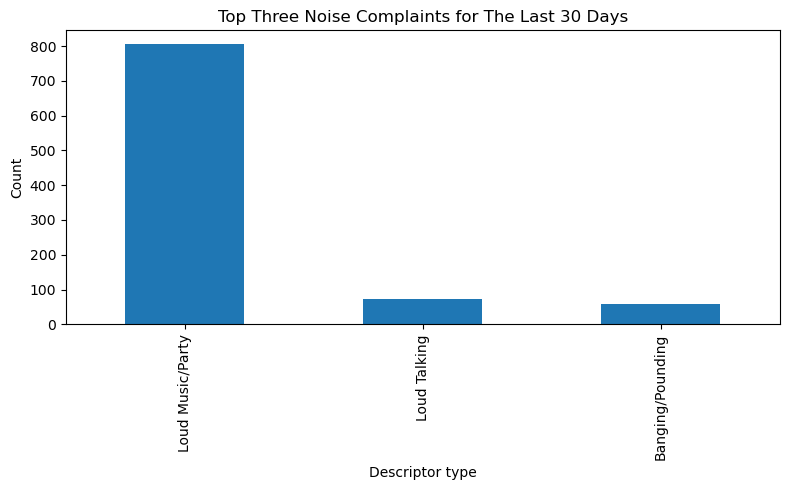

,complaint_type,borough,created_date,descriptor
0,Noise - Street/Sidewalk,MANHATTAN,2025-05-04 01:51:11,Loud Music/Party
1,Noise - Vehicle,MANHATTAN,2025-05-04 01:51:01,Car/Truck Music
2,Noise - Residential,STATEN ISLAND,2025-05-04 01:50:47,Loud Music/Party
3,Noise - Street/Sidewalk,BROOKLYN,2025-05-04 01:50:46,Loud Music/Party
4,Noise - Residential,QUEENS,2025-05-04 01:50:40,Loud Music/Party
...,...,...,...,...
995,Noise - Residential,QUEENS,2025-05-03 23:15:27,Loud Music/Party
996,Noise - Street/Sidewalk,QUEENS,2025-05-03 23:15:24,Loud Music/Party
997,Noise - Residential,QUEENS,2025-05-03 23:15:22,Banging/Pounding
998,Noise - Residential,BROOKLYN,2025-05-03 23:15:20,Loud Music/Party


In [3]:
#run for part 1 and 2
df_noise = noise_complaints(days_back = 30, limit = 1000)

df_clean, top_three = noise_data(df_noise, drop_null_descriptor = True)

display(df_clean.head(1000))


Top Three Noise Complaint Descriptors (Last 30 Days)

Based on 1,000 service requests pulled from NYC’s Open Data API for the past 30 days, these three noise descriptors dominate complaints across all five boroughs:

1. **Loud Music/Party (747 complaint)**:
- This type of noise outweighs the other three by a landslide. It may suggest that this can be caused by neighborhood parties, or excessive music  being played by residents. Based on the data alone, you can see that this is the biggest source of noise disturbanceance.

2. **Loud Talking (87 complaints)**:
- This type of noise had a total of 87 complaints, which may suggest that gatherings in public/private places can be the root cause of this type of noise. It can even be caused by loud neighbors who are generally just loud speakers.

4. **Car/Truck Music (55 complaints)**:
- This may suggest that cars passing by residential areas may be excessively loud, which can be caused by car modifications, it can also be due to car alarm systems going off, or by cars/trucks honking excessively, and by cars blasting music as they are driving. 


In [4]:
import pandas as pd
def noise_by_boroughs(df: pd.DataFrame) -> (pd.Series, pd.DataFrame):

    # Used to count total noise complaints generated by each borough
    borough_total_count = df['borough'].value_counts()

    # Builds us a pivot table, to group complaint counts by boroughs and descriptors
    borough_descriptor_pivot = (
        df
        .groupby(['borough', 'descriptor']) #groups boroughs to descriptors
        .size() 
        .unstack(fill_value = 0) # Unstacks in order for each descriptor to be its own column, fill any missing ones with 0
    )
    return borough_total_count, borough_descriptor_pivot

Dataset shape: 1000 rows × 4 cols

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   complaint_type  1000 non-null   object        
 1   borough         1000 non-null   object        
 2   created_date    1000 non-null   datetime64[ns]
 3   descriptor      1000 non-null   object        
dtypes: datetime64[ns](1), object(3)
memory usage: 31.4+ KB

Missing values per column:
complaint_type    0
borough           0
created_date      0
descriptor        0
dtype: int64

Top 3 Noise Descriptors:
descriptor
Loud Music/Party    805
Loud Talking         72
Banging/Pounding     58
Name: count, dtype: int64


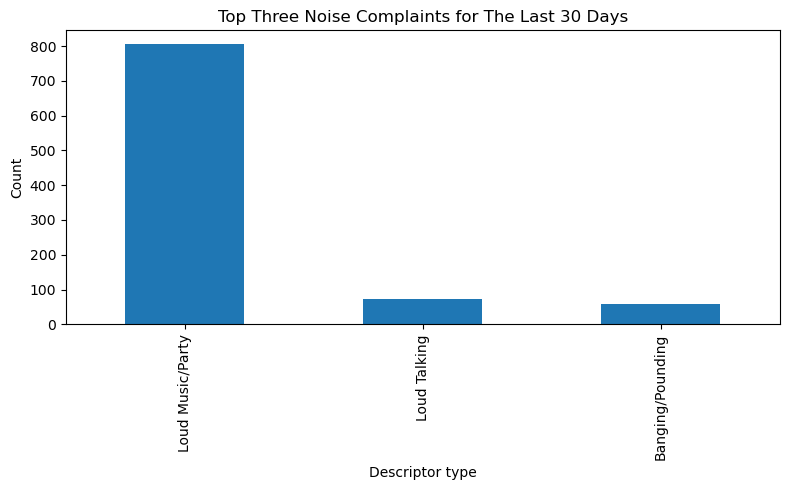

Total noise complaints by borough:

borough
QUEENS           379
BROOKLYN         274
BRONX            166
MANHATTAN        162
STATEN ISLAND     19
Name: count, dtype: int64


descriptor,Banging/Pounding,Car/Truck Horn,Car/Truck Music,Engine Idling,Loud Music/Party,Loud Talking,Loud Television,"Noise, Barking Dog (NR5)",Noise: Construction Before/After Hours (NM1),Noise: air condition/ventilation equipment (NV1)
borough,,,,,,,,,,
BRONX,13,2,15,0,128,6,1,0,0,1
BROOKLYN,13,0,4,1,228,27,0,0,0,1
MANHATTAN,6,5,7,0,118,24,0,1,1,0
QUEENS,24,0,23,3,316,13,0,0,0,0
STATEN ISLAND,2,0,0,0,15,2,0,0,0,0


In [5]:
#Run for part 3
df_noise = noise_complaints(days_back=30, limit=1000)
df_clean, top_three = noise_data(df_noise, drop_null_descriptor=True)
borough_total_count, borough_descriptor_pivot = noise_by_boroughs(df_clean)

print("Total noise complaints by borough:\n")
print(borough_total_count)

display(borough_descriptor_pivot)


## Borough Insights from the previous 30 days:

1. **Loudest Borough**  
   - Based on the data that's been retrieved, it is notable that the borough with the most reported noise is Manhattan. This was expected as it is the heart of NYC. It's been reported that it has had 294 in the past 30 days.

2. **Commonality between boroughs**  
   - Among the 5 boroughs, it is widely reported that Descriptor type Loud Music/Party is the most reported type of noise among the five. However, it truly triumphs within the Bronx, Manhattan, and Brooklyn. This aligns with Brooklyn’s large population, Manhattan’s active nightlife scene, and the concentration of multi-unit housing in the Bronx.  
   - Banging/Pounding is the highest in Brooklyn, and this is likely driven by its industrial zones and ongoing construction/maintenance work.

4. **Patterns/Observations**  
   - Within the five boroughs, I noticed that Loud Music/Party is the most reported noise complaint, and it was expected because of the large populations of each borough.  
   - It’s notable that Manhattan tops the overall list, even though its residential population is smaller (around 1.7 million) than Brooklyn’s and Queens’s (with each over 2.4 M).  
   - Car/Truck Horn complaints remain relatively low across all boroughs, which is surprising considering the city’s heavy traffic volume.
l list, even though its residential population is smaller (around 1.7 million) than Brooklyn’s and Queens’s (with each over 2.4 M).
-Car/Truck Horn complaints remain relatively low across all boroughs, which is surprising considering the city’s heavy traffic volume.

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

def build_visualization(borough_total_count: pd.Series,
                        borough_descriptor_pivot: pd.DataFrame,
                        df: pd.DataFrame):
    # Bar chart per borough
    plt.figure(figsize = (6, 4))
    borough_total_count.plot.bar()
    plt.title("# Of Noise Complaints Per Borough")
    plt.xticks(rotation = 45)
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()

    # Horizontal bar chart of top-5 descriptors
    top_five = df['descriptor'].value_counts().head(5)
    plt.figure(figsize = (6,4))
    top_five.plot.barh()
    plt.title("Top 5 Noise Complaint Descriptors")
    plt.xlabel("Count")
    plt.tight_layout()
    plt.show()

    # Heatmap: Borough Vs Descriptor
    plt.figure(figsize = (16,8))
    sns.heatmap(
        borough_descriptor_pivot,
        annot = True, fmt = "d",
        cmap = "YlGnBu",
        linewidths = 0.5,
        cbar_kws = {"shrink": 0.5}
    )
    plt.title("Heatmap: Borough vs. All Noise Complaint Descriptors")
    plt.xlabel("Descriptor")
    plt.ylabel("Borough")
    plt.xticks(rotation = 45, ha = "right")
    plt.tight_layout()
    plt.show()

    # Pie Chart for Descriptors. Also to
    complaint_counts = df['complaint_type'].value_counts()
    top_Five = complaint_counts.head(5).copy()
    top_Five['Other'] = complaint_counts.iloc[5:].sum()

    plt.figure(figsize = (6, 6))
    top_Five.plot.pie(
        autopct = '%1.1f%%',
        startangle = 90,
        counterclock = False
    )
    plt.title("Major Noise Complaint Types (Others grouped)")
    plt.tight_layout()
    plt.show()

    # Bubble chart for Borough Vs Descriptor and its Complaint counts
    bubble_data = (
        borough_descriptor_pivot
        .reset_index()
        .melt(id_vars = "borough", var_name = "descriptor", value_name = "count")
    )
    plt.figure(figsize = (12, 6))
    sns.scatterplot(
        data = bubble_data,
        x = "descriptor",
        y = "borough",
        size = "count",
        sizes = (20, 2000),
        alpha = 0.7,
        legend = "brief"
    )
    plt.title("Bubble Chart: Borough vs. Descriptor Complaint Counts")
    plt.xlabel("Descriptor")
    plt.ylabel("Borough")
    plt.xticks(rotation = 45, ha = "right")
    plt.tight_layout()
    plt.show()


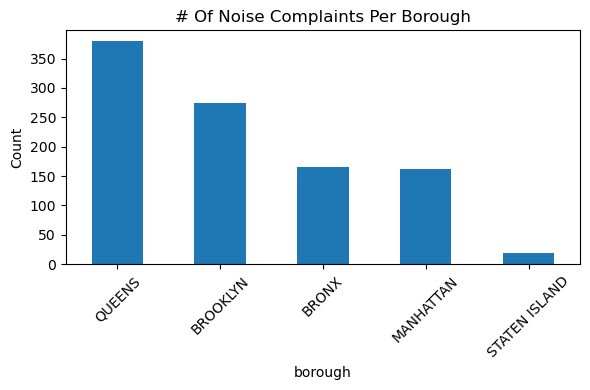

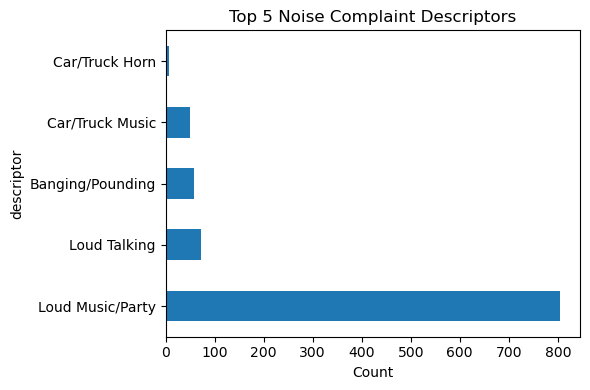

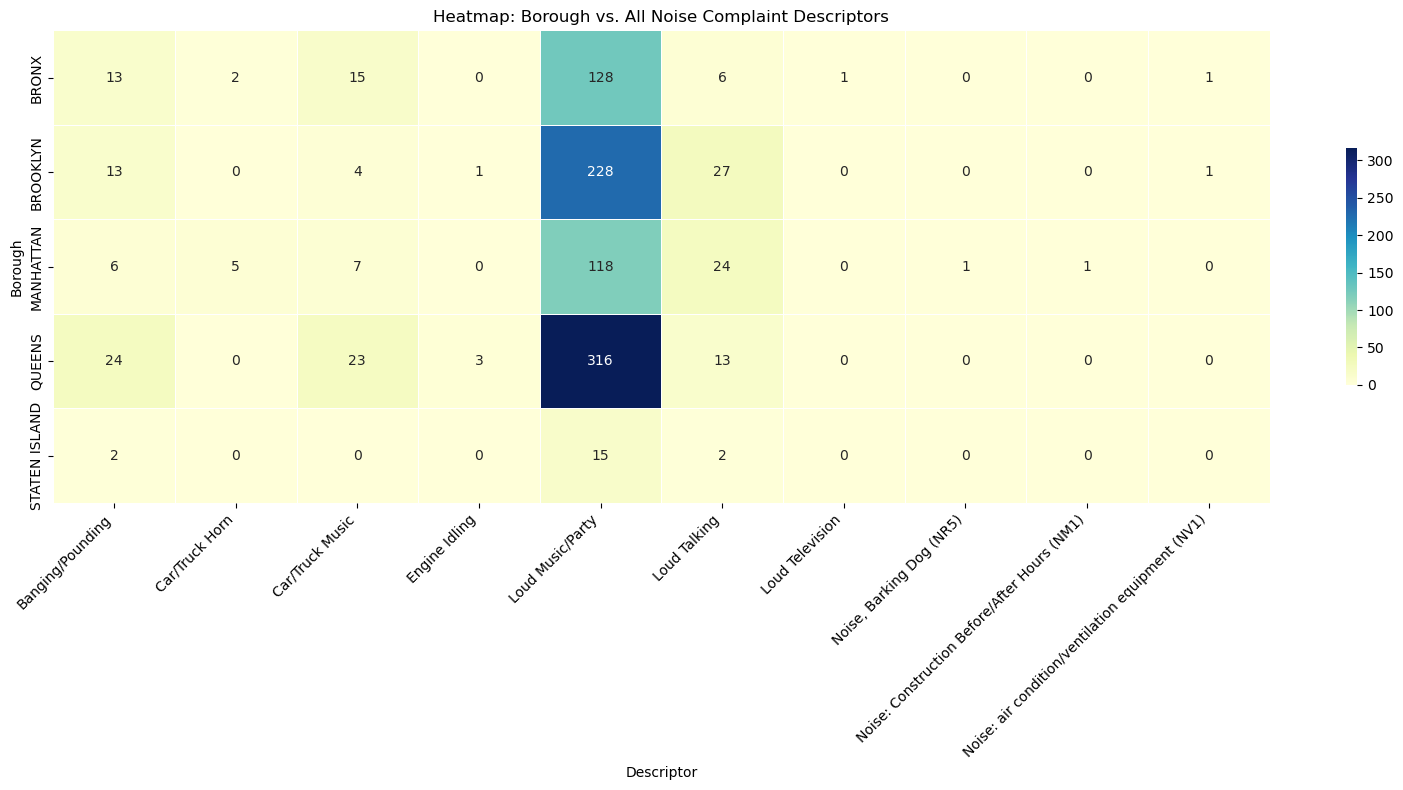

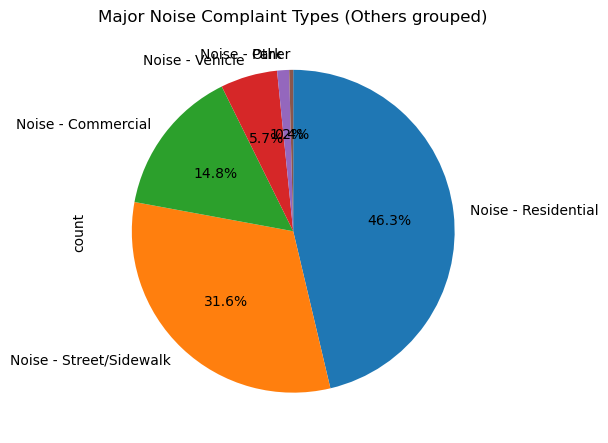

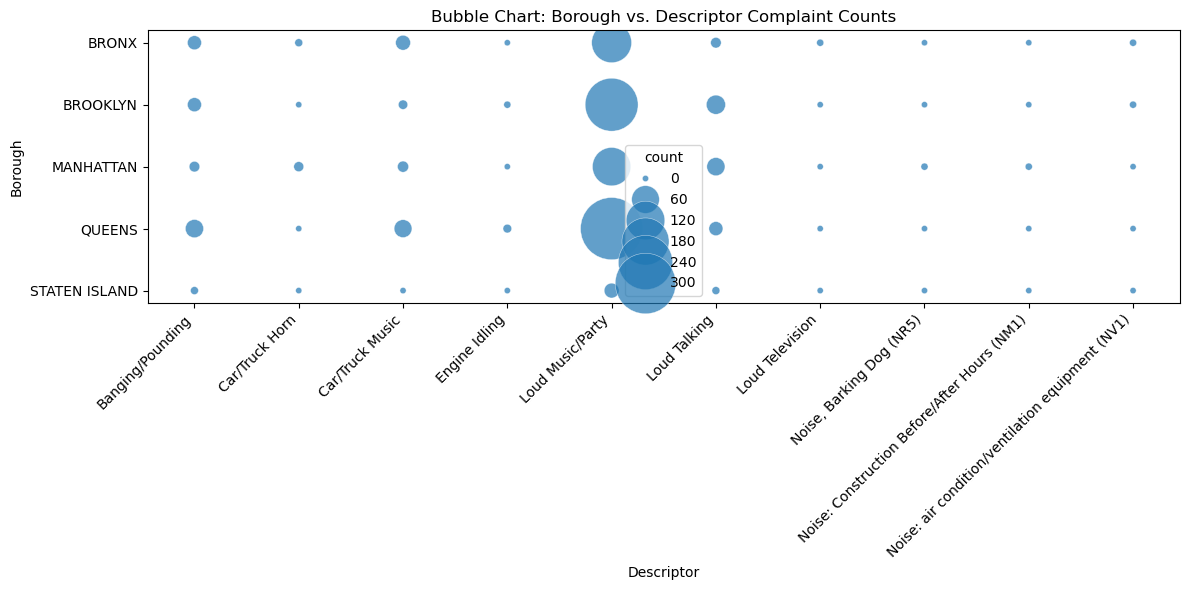

In [9]:
# Run for part 4
borough_total_count, borough_descriptor_pivot = noise_by_boroughs(df_clean)
build_visualization(
    borough_total_count,
    borough_descriptor_pivot,
    df_clean
)


Description of the Data Visualizations

1. **Noise Complaints by Borough (Bar Chart)**  
   - This bar chart shows the total number of noise complaints filed in each borough over the past 30 days. Rather than breaking complaints down by type, it aggregates them all together to highlight which boroughs generate the most overall noise reports.

2. **Top 5 Noise Complaint Descriptors (Horizontal Bar Chart)**  
   - This chart ranks the five most common noise complaint types city-wide. It clearly showshat **Loud Musicarty** far outpaces the others—more than doubling the complaint count of any other category.

3. **Borough vs. Descriptor Heatmap**  
   - This heatmap maps each noise descriptor to its borough and displays the volume of complaints for each combination. Oncagain, **Loud Muc/Party** stands out as the dominant issue, with the highest concentration of complaints across multiple 
  
4. **Pie Chart of Noise Complaint Descriptors**  
   - Including this pie chart is essential because it clearly breaks down the most frequently reported noise complaint descriptors by their share of total complaints. By combining the less common complaint types into an “Other” slice, it highlights which issues dominate the conversation and where resources should be concentrated to have the greatest impact on reducing noise disturbances.

5. **Bubble Chart: Borough vs. Descriptor Complaint Counts**  
   - This bubble chart visualizes each borough–descriptor combination as a circle whose size reflects the number of complaints. It offers a quick, intuitive way to compare both the overall prominence of different noise types and how they vary across boroughs. Larger bubbles draw attention to the most significant problem areas, guiding targeted interventions where they’re needed most.oroughs.
